## Image Recognition using CNN

I have used the CIFAR-10 dataset, which is very famous dataset for image recognition! 

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 


In [0]:
CIFAR_DIR = 'cifar-10-batches-py/'

The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle. 



In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [0]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [0]:
all_data = [0,1,2,3,4,5,6]

In [0]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [0]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [0]:
batch_meta

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

In [0]:
data_batch1.keys()

dict_keys([b'data', b'batch_label', b'labels', b'filenames'])

Loaded in this way, each of the batch files contains a dictionary with the following elements:
* data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
* labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

* label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [0]:
X = data_batch1[b"data"] 

In [0]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [0]:
X[0].max()

255

In [0]:
(X[0]/255).max()

1.0

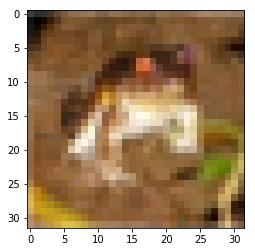

In [0]:
plt.imshow(X[0])

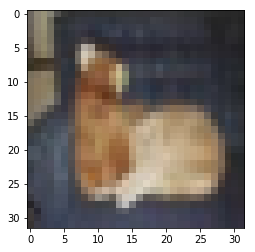

In [0]:
plt.imshow(X[17])

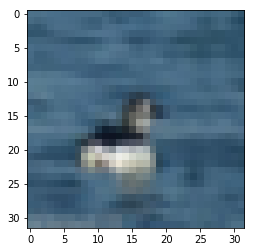

In [0]:
plt.imshow(X[47])

# Helper Functions

In [0]:
def one_hot_encode(vec, vals=10):
    
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [0]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [0]:
ch = CifarHelper()
ch.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


##  Model



In [0]:
import tensorflow as tf

In [0]:
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])

In [0]:
hold_prob = tf.placeholder(tf.float32)

In [0]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

### Layers

** Created a convolutional layer and a pooling layer . **


In [0]:
convo_1 = convolutional_layer(x,shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [0]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [0]:
8*8*64

4096

In [0]:
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])

In [0]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [0]:
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [0]:
y_pred = normal_full_layer(full_one_dropout,10)

### Loss Function



In [0]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

### Optimizer


In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [0]:
init = tf.global_variables_initializer()

## Graph Session



In [0]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(5000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.0991


Currently on step 100
Accuracy is:
0.4162


Currently on step 200
Accuracy is:
0.4746


Currently on step 300
Accuracy is:
0.5017


Currently on step 400
Accuracy is:
0.5125


Currently on step 500
Accuracy is:
0.5276


Currently on step 600
Accuracy is:
0.5461


Currently on step 700
Accuracy is:
0.5688


Currently on step 800
Accuracy is:
0.5804


Currently on step 900
Accuracy is:
0.5662


Currently on step 1000
Accuracy is:
0.6098


Currently on step 1100
Accuracy is:
0.6118


Currently on step 1200
Accuracy is:
0.6083


Currently on step 1300
Accuracy is:
0.6193


Currently on step 1400
Accuracy is:
0.6234


Currently on step 1500
Accuracy is:
0.6414


Currently on step 1600
Accuracy is:
0.649


Currently on step 1700
Accuracy is:
0.6609


Currently on step 1800
Accuracy is:
0.6513


Currently on step 1900
Accuracy is:
0.6504


Currently on step 2000
Accuracy is:
0.6579


Currently on step 2100
Accuracy is:
0.6762


Currently on step 2200


## Our Models Accuracy Rate is 70%